In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Embedding, Attention, LayerNormalization, Dense
from sklearn import tree
from tensorflow.keras import models, layers
import warnings

from keras.metrics import Recall
from keras.metrics import Accuracy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv('clean_sql_dataset - Copy.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149435 entries, 0 to 149434
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Query   149434 non-null  object
 1   Label   149435 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [4]:
df.dropna(inplace=True)

In [5]:
X=df['Query']
y=df['Label']

In [6]:
max_words = len(list(X.str.split(' ', expand=True).stack().unique()))
max_words

611692

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(119547,)
(119547,)
(29887,)
(29887,)


In [9]:
train_shape = X_train.shape[1:]

In [10]:
max_words = 611692
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [11]:
from keras.models import Sequential
model = Sequential(name="RNN")
model.add(Embedding(max_words,100,input_length=max_len))
model.add(layers.SimpleRNN(units=64, activation='relu'))

# Add a Dense layer for classification (adjust units and activation as needed)
model.add(layers.Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history_rnn = model.fit(sequences_matrix,y_train, batch_size=128, epochs=10,
                   validation_split=0.2,callbacks=[callbacks])



Epoch 1/10


748/748 [==============================] - 247s 328ms/step - loss: 225.5985 - accuracy: 0.8812 - val_loss: 0.3419 - val_accuracy: 0.8923
Epoch 2/10
748/748 [==============================] - 233s 311ms/step - loss: 0.1884 - accuracy: 0.9437 - val_loss: 0.1823 - val_accuracy: 0.9504
Epoch 3/10
748/748 [==============================] - 239s 319ms/step - loss: 0.1159 - accuracy: 0.9652 - val_loss: 0.1647 - val_accuracy: 0.9562
Epoch 4/10
748/748 [==============================] - 236s 315ms/step - loss: 0.0882 - accuracy: 0.9709 - val_loss: 0.1582 - val_accuracy: 0.9579
Epoch 5/10
748/748 [==============================] - 234s 313ms/step - loss: 15.1266 - accuracy: 0.9633 - val_loss: 0.1989 - val_accuracy: 0.9487
Epoch 6/10
748/748 [==============================] - 238s 318ms/step - loss: 0.0782 - accuracy: 0.9745 - val_loss: 0.1943 - val_accuracy: 0.9490
Epoch 7/10
748/748 [==============================] - 235s 314ms/step - loss: 0.0623 - accuracy: 0.9791 - val_loss: 0

In [12]:
X_test_sequences = tok.texts_to_sequences(X_test)
X_test_sequences_matrix = sequence.pad_sequences(X_test_sequences,maxlen=max_len)

In [13]:
y_pred=model.predict(X_test_sequences_matrix)

934/934 [==============================] - 4s 4ms/step


In [14]:
print(y_pred)

[[0.99594164]
 [0.98553914]
 [0.97083277]
 ...
 [0.16780023]
 [0.05174875]
 [0.99467635]]


In [15]:
for i in range(len(y_pred)):
    if y_pred[i]>0.5:
        y_pred[i]=1
    elif y_pred[i]<=0.5:
        y_pred[i]=0

In [16]:
print(y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [17]:
f1_dict = {}
precision_dict = {}
recall_dict = {}
accuracy_dict = {}
train_accuracy = {}
validation_accuracy = {}
test_accuracy = {}

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
test_accuracy["RNN"] = accuracy_score(y_test, y_pred)
precision_dict["RNN"] = precision_score(y_test, y_pred, zero_division=1)
recall_dict["RNN"]= recall_score(y_test, y_pred, zero_division=1)
f1_dict["RNN"] = f1_score(y_test, y_pred, zero_division=1)
print(" Accuracy : {0} \n Precision : {1} \n Recall : {2} \n F1 : {3}".format(accuracy, precision, recall, f1_score))

 Accuracy : 0.9489075517783652 
 Precision : 0.9776926694886784 
 Recall : 0.9241077098945764 
 F1 : 0.9501452871461686


In [19]:
key1 = f1_dict, precision_dict, recall_dict, test_accuracy
metrics = ['F1_Score', 'Precision', 'Recall', 'Accuracy']
data = pd.DataFrame(key1)
data.index = metrics
data

,RNN
F1_Score,0.950145
Precision,0.977693
Recall,0.924108
Accuracy,0.948908


In [90]:
cf_matrix = confusion_matrix(y_test,y_pred)
print(cf_matrix)

[[13809   332]
 [ 1195 14551]]


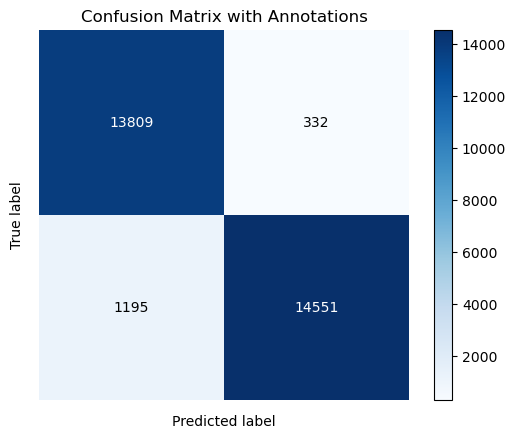

In [150]:
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.imshow(cf_matrix, cmap='Blues')

# Add a color bar
cbar = plt.colorbar()

# Add labels to the x and y axes
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add annotations (numbers) to the heatmap
thresh = cf_matrix.max() / 2.0
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j],'d'),ha="center", va="center",color="white" if cf_matrix[i, j] > thresh else "black")


# Set the title
plt.title('Confusion Matrix with Annotations')

# Hide the ticks and tick labels
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 
plt.gca().xaxis.set_ticklabels([]) 
plt.gca().yaxis.set_ticklabels([])

# Hide the spines (the lines that make up the box)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.axis('off')

# Display the plot
plt.show()

In [22]:
from keras.models import load_model
from pathlib import Path

model.save_weights("lstm_weights_RNNModifiedDataset.h5")
print('done')

model.save('lstm_model_RNNModifiedDataset.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [152]:
from keras.models import Sequential
model = Sequential(name="CNN")
model.add(Embedding(max_words,100,input_length=max_len))
model.add(layers.Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])


Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          61169200  
                                                                 
 conv1d (Conv1D)             (None, 147, 32)           12832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 73, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 70, 64)            8256      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 35, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 128)           32896  

In [154]:
callbacks = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)
history = model.fit(sequences_matrix,y_train, batch_size=128, epochs=10,
                   validation_split=0.2,callbacks=[callbacks])

Epoch 1/10
748/748 [==============================] - 221s 294ms/step - loss: 0.0970 - accuracy: 0.9625 - val_loss: 0.0432 - val_accuracy: 0.9884
Epoch 2/10
748/748 [==============================] - 220s 294ms/step - loss: 0.0285 - accuracy: 0.9924 - val_loss: 0.0433 - val_accuracy: 0.9888
Epoch 3/10
748/748 [==============================] - 220s 293ms/step - loss: 0.0199 - accuracy: 0.9943 - val_loss: 0.0531 - val_accuracy: 0.9869
Epoch 4/10
748/748 [==============================] - 220s 294ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0632 - val_accuracy: 0.9865


In [156]:
y_pred_CNN=model.predict(X_test_sequences_matrix)

934/934 [==============================] - 3s 3ms/step


In [158]:
for i in range(len(y_pred_CNN)):
    if y_pred_CNN[i]>0.5:
        y_pred_CNN[i]=1
    elif y_pred_CNN[i]<=0.5:
        y_pred_CNN[i]=0

In [160]:
print(y_pred_CNN)

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [162]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
test_accuracy["CNN"] = accuracy_score(y_test, y_pred_CNN)
precision_dict["CNN"] = precision_score(y_test, y_pred_CNN, zero_division=1)
recall_dict["CNN"]= recall_score(y_test, y_pred_CNN, zero_division=1)
f1_dict["CNN"] = f1_score(y_test, y_pred_CNN, zero_division=1)

In [164]:
key1 = f1_dict, precision_dict, recall_dict, test_accuracy
metrics = ['F1_Score', 'Precision', 'Recall', 'Accuracy']
data = pd.DataFrame(key1)
data.index = metrics
data

,RNN,CNN
F1_Score,0.950145,0.987064
Precision,0.977693,0.995415
Recall,0.924108,0.978852
Accuracy,0.948908,0.986482


In [166]:
cf_matrix = confusion_matrix(y_test,y_pred_CNN)
print(cf_matrix)

[[14070    71]
 [  333 15413]]


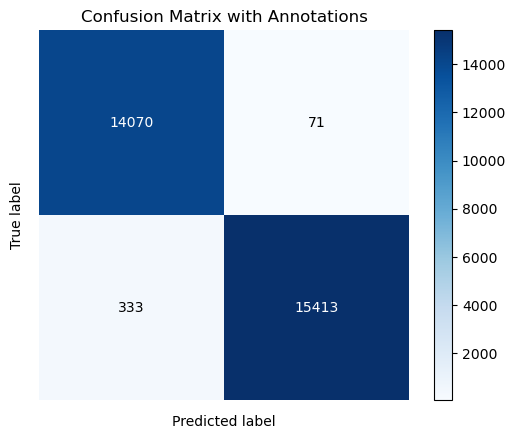

In [168]:
import matplotlib.pyplot as plt
import numpy as np

# Create the heatmap
plt.imshow(cf_matrix, cmap='Blues')

# Add a color bar
cbar = plt.colorbar()

# Add labels to the x and y axes
plt.xlabel('Predicted label')
plt.ylabel('True label')

# Add annotations (numbers) to the heatmap
thresh = cf_matrix.max() / 2.0
for i in range(cf_matrix.shape[0]):
    for j in range(cf_matrix.shape[1]):
        plt.text(j, i, format(cf_matrix[i, j],'d'),ha="center", va="center",color="white" if cf_matrix[i, j] > thresh else "black")


# Set the title
plt.title('Confusion Matrix with Annotations')

# Hide the ticks and tick labels
plt.gca().xaxis.set_ticks_position('none') 
plt.gca().yaxis.set_ticks_position('none') 
plt.gca().xaxis.set_ticklabels([]) 
plt.gca().yaxis.set_ticklabels([])

# Hide the spines (the lines that make up the box)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# plt.axis('off')

# Display the plot
plt.show()

In [170]:
from keras.models import load_model
from pathlib import Path

model.save_weights("weights_CNNModifiedDataset.h5")
print('done')

model.save('model_CNNModifiedDataset.h5')

done


C:\Users\Huang\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


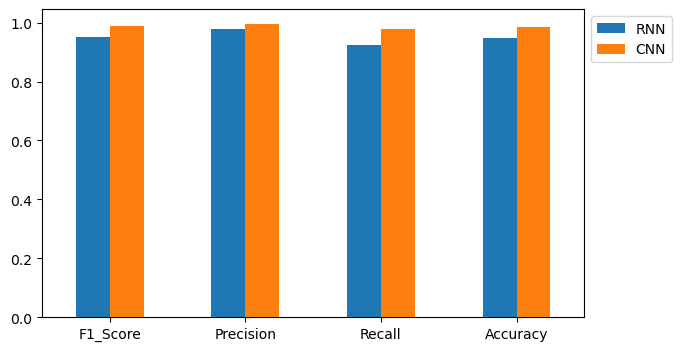

In [172]:
result = data.plot(kind='bar', rot=0, figsize=(7, 4));
result.legend(bbox_to_anchor=(1, 1), loc='upper left');